### **Load Libraries & Dataset Paths**

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import resample
import tensorflow as tf
import time
from datetime import datetime
from datetime import timedelta
import json
import os
import glob

# let here be all the paths and datsets
train_dir = "/content/drive/MyDrive/chest_xray/train"
test_dir  = "/content/drive/MyDrive/chest_xray/test"
model_dir = "/content/drive/MyDrive/chest_xray/vgg16_models"
os.makedirs(model_dir, exist_ok=True)

# Helper to build dataframe from folder structure
def build_df_from_folder(folder):
    rows = []
    classes = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])
    for cls in classes:
        class_path = os.path.join(folder, cls)
        for ext in ("*.png", "*.jpg", "*.jpeg"):
            for p in glob.glob(os.path.join(class_path, ext)):
                rows.append({"path": p, "target_str": cls})
    df = pd.DataFrame(rows)
    return df

# Build dataframes from directories
train_all = build_df_from_folder(train_dir)
test_data = build_df_from_folder(test_dir)

In [ ]:

# Map class names to numeric labels (0,1). If more than 2 classes exist, mapping will still be deterministic.
unique_classes = sorted(train_all['target_str'].unique())
class_map = {name: i for i, name in enumerate(unique_classes)}
train_all['target'] = train_all['target_str'].map(class_map).astype(float)
test_data['target'] = test_data['target_str'].map(class_map).astype(float)


# Split train -> final_train_data + val_data
final_train_data, val_data = train_test_split(
    train_all,
    test_size=0.1,
    stratify=train_all['target'],
    random_state=42
)

# Ensure columns used by flow_from_dataframe exist and are correct
final_train_data = final_train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


In [ ]:
print("Dataset sizes:")
print(f"  Train: {len(final_train_data)}")
print(f"  Val:   {len(val_data)}")
print(f"  Test:  {len(test_data)}")

Dataset sizes:
  Train: 4708
  Val:   524
  Test:  624


In [ ]:
# DATA GENERATORS
train_datagen = ImageDataGenerator(
    rescale=1./255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.9,1.1]
)

val_test_datagen = ImageDataGenerator(rescale=1./255.0)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=final_train_data,
    directory=None,
    x_col='path',
    y_col='target',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=32,
    seed=1000
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=None,
    x_col='path',
    y_col='target',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=32,
    seed=1000
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=None,
    x_col='path',
    y_col='target',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=len(test_data),  # Single batch for evaluation
    shuffle=False,
    seed=1000
)

Found 4708 validated image filenames.
Found 524 validated image filenames.
Found 624 validated image filenames.


In [ ]:
# MODEL DEFINITION

def build_vgg16_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Freeze all layers except last conv block
    for layer in base_model.layers:
        layer.trainable = (layer.name == "block5_conv3")

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=3e-3),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
        ]
    )
    return model

model = build_vgg16_model()
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 2,491,393 (9.50 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [ ]:
# TRAINING UTILITIES
class TrainingTracker:
    def __init__(self):
        self.start_time = None
        self.total_seconds = 0
        self.sessions = []

    def start_session(self):
        self.start_time = time.time()

    def end_session(self):
        if self.start_time:
            duration = time.time() - self.start_time
            self.total_seconds += duration
            self.sessions.append(duration)
            self.start_time = None

    def get_elapsed_time(self):
        return str(timedelta(seconds=int(self.total_seconds)))

    def save_progress(self, path):
        with open(path, 'w') as f:
            f.write(f"Total Training Time: {self.get_elapsed_time()}\n")
            f.write(f"Completed Sessions: {len(self.sessions)}\n")
            for i, session in enumerate(self.sessions, 1):
                f.write(f"Session {i}: {timedelta(seconds=int(session))}\n")

def get_model_size_mb(model_path):
    return os.path.getsize(model_path) / (1024 * 1024)

def load_previous_state(model_dir):
    # look for previous best files (if any)
    model_files = sorted(glob.glob(os.path.join(model_dir, 'Vgg16_Best_*.h5')))
    if not model_files:
        return None, 0

    latest_model = model_files[-1]
    # no epoch encoding in best filename; return 0 for start epoch
    return latest_model, 0

In [ ]:
# Calculate class weights
class_counts = final_train_data['target'].value_counts()
total_samples = class_counts.sum()
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

In [ ]:
# TRAINING EXECUTION

# Initialize tracker and model directory
os.makedirs(model_dir, exist_ok=True)
tracker = TrainingTracker()
model_path, start_epoch = load_previous_state(model_dir)

if model_path:
    print(f"Resuming training from {model_path}")
    try:
        model = load_model(model_path, compile=False)
        model.compile(
            optimizer=Adam(learning_rate=3e-3),
            loss='binary_crossentropy',
            metrics=[
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
            ]
        )
        # Load previous training time
        time_log = os.path.join(model_dir, 'training_time.log')
        if os.path.exists(time_log):
            with open(time_log, 'r') as f:
                time_str = f.readline().split(': ')[1].strip()
                h, m, s = map(int, time_str.split(':'))
                tracker.total_seconds = h*3600 + m*60 + s
    except Exception as e:
        print(f"Failed to load model: {e}\nInitializing new model")
        model = build_vgg16_model()
        start_epoch = 0
else:
    print("No previous model found - initializing new model")
    model = build_vgg16_model()
    start_epoch = 0

# Training callbacks
# only save the best model (monitored on val_loss)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
best_model_filename = f"Vgg16_Best_{timestamp}.h5"

callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(model_dir, best_model_filename),
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.8,
        patience=4,
        min_lr=0.0001,
        cooldown=5
    ),
    tf.keras.callbacks.LambdaCallback(
        on_train_begin=lambda logs: tracker.start_session(),
        on_train_end=lambda logs: tracker.end_session(),
        on_epoch_end=lambda epoch, logs: (
            tracker.save_progress(os.path.join(model_dir, 'training_time.log')),
            print(f"Epoch {epoch+1:02d} | "
                  f"Elapsed: {tracker.get_elapsed_time()}")
        )
    )
]

# Start training
print(f"\n{'='*50}")
print("\nTraining Summary:")
print(f"Training Samples: {len(final_train_data)}")
print(f"Validation Samples: {len(val_data)}")
print(f"Starting Epoch: {start_epoch + 1}")
#print(f"Current Time: {tracker.get_elapsed_time()}\n")
print(f"{'='*50}\n")

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=30,
    initial_epoch=start_epoch,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks,
    #class_weight=class_weights, # Add class weights here
    verbose=1
)

No previous model found - initializing new model


Training Summary:
Training Samples: 4708
Validation Samples: 524
Starting Epoch: 1

Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - auc: 0.8339 - binary_accuracy: 0.8211 - loss: 0.5774 - precision: 0.8748 - recall: 0.8843 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.14890, saving model to /content/drive/MyDrive/chest_xray/vgg16_models/Vgg16_Best_20250818_111540.h5


Epoch 01 | Elapsed: 0:00:00
148/148 ━━━━━━━━━━━━━━━━━━━━ 3136s 21s/step - auc: 0.8345 - binary_accuracy: 0.8216 - loss: 0.5756 - precision: 0.8751 - recall: 0.8845 - val_auc: 0.9851 - val_binary_accuracy: 0.9370 - val_loss: 0.1489 - val_precision: 0.9863 - val_recall: 0.9280 - learning_rate: 0.0030
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - auc: 0.9799 - binary_accuracy: 0.9374 - loss: 0.1515 - precision: 0.9638 - recall: 0.9529 
Epoch 2: val_loss did not improve from 0.14890
Epoch 02 | Elapsed: 0:00:00
148/148 ━━━━━━━━━━━━━━━━━━━━ 3037s 21s/step - auc: 0.9799 - binary_accuracy: 0.9374 - loss: 0.1515 - precision: 0.9638 - recall: 0.9530 - val_auc: 0.9891 - val_binary_accuracy: 0.8989 - val_loss: 0.2940 - val_precision: 0.9970 - val_recall: 0.8663 - learning_rate: 0.0030
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - auc: 0.9857 - binary_accuracy: 0.9493 - loss: 0.1342 - precision: 0.9671 - recall: 0.9638 
Epoch 3: val_loss did not improve from 0.14890
Epoch 03 | Elaps

Epoch 05 | Elapsed: 0:00:00
148/148 ━━━━━━━━━━━━━━━━━━━━ 3074s 21s/step - auc: 0.9912 - binary_accuracy: 0.9599 - loss: 0.1030 - precision: 0.9745 - recall: 0.9713 - val_auc: 0.9926 - val_binary_accuracy: 0.9504 - val_loss: 0.1248 - val_precision: 0.9946 - val_recall: 0.9383 - learning_rate: 0.0030
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - auc: 0.9890 - binary_accuracy: 0.9602 - loss: 0.1063 - precision: 0.9728 - recall: 0.9742 
Epoch 6: val_loss did not improve from 0.12479
Epoch 06 | Elapsed: 0:00:00
148/148 ━━━━━━━━━━━━━━━━━━━━ 3044s 21s/step - auc: 0.9890 - binary_accuracy: 0.9602 - loss: 0.1063 - precision: 0.9729 - recall: 0.9743 - val_auc: 0.9945 - val_binary_accuracy: 0.9408 - val_loss: 0.1456 - val_precision: 0.9972 - val_recall: 0.9229 - learning_rate: 0.0030
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - auc: 0.9948 - binary_accuracy: 0.9713 - loss: 0.0736 - precision: 0.9826 - recall: 0.9789 
Epoch 7: val_loss improved from 0.12479 to 0.11006, saving mode

Epoch 07 | Elapsed: 0:00:00
148/148 ━━━━━━━━━━━━━━━━━━━━ 3028s 20s/step - auc: 0.9948 - binary_accuracy: 0.9713 - loss: 0.0736 - precision: 0.9826 - recall: 0.9789 - val_auc: 0.9951 - val_binary_accuracy: 0.9542 - val_loss: 0.1101 - val_precision: 0.9919 - val_recall: 0.9460 - learning_rate: 0.0030
Epoch 8/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - auc: 0.9929 - binary_accuracy: 0.9707 - loss: 0.0794 - precision: 0.9850 - recall: 0.9763 
Epoch 8: val_loss improved from 0.11006 to 0.09068, saving model to /content/drive/MyDrive/chest_xray/vgg16_models/Vgg16_Best_20250818_111540.h5


Epoch 08 | Elapsed: 0:00:00
148/148 ━━━━━━━━━━━━━━━━━━━━ 3091s 21s/step - auc: 0.9929 - binary_accuracy: 0.9707 - loss: 0.0793 - precision: 0.9850 - recall: 0.9763 - val_auc: 0.9934 - val_binary_accuracy: 0.9618 - val_loss: 0.0907 - val_precision: 0.9792 - val_recall: 0.9692 - learning_rate: 0.0030
Epoch 9/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - auc: 0.9936 - binary_accuracy: 0.9716 - loss: 0.0825 - precision: 0.9791 - recall: 0.9835 
Epoch 9: val_loss did not improve from 0.09068
Epoch 09 | Elapsed: 0:00:00
148/148 ━━━━━━━━━━━━━━━━━━━━ 3035s 21s/step - auc: 0.9936 - binary_accuracy: 0.9716 - loss: 0.0824 - precision: 0.9791 - recall: 0.9835 - val_auc: 0.9933 - val_binary_accuracy: 0.9370 - val_loss: 0.1871 - val_precision: 0.9972 - val_recall: 0.9177 - learning_rate: 0.0030
Epoch 10/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - auc: 0.9943 - binary_accuracy: 0.9706 - loss: 0.0794 - precision: 0.9841 - recall: 0.9765 
Epoch 10: val_loss did not improve from 0.09068
Epoch 10 | Ela

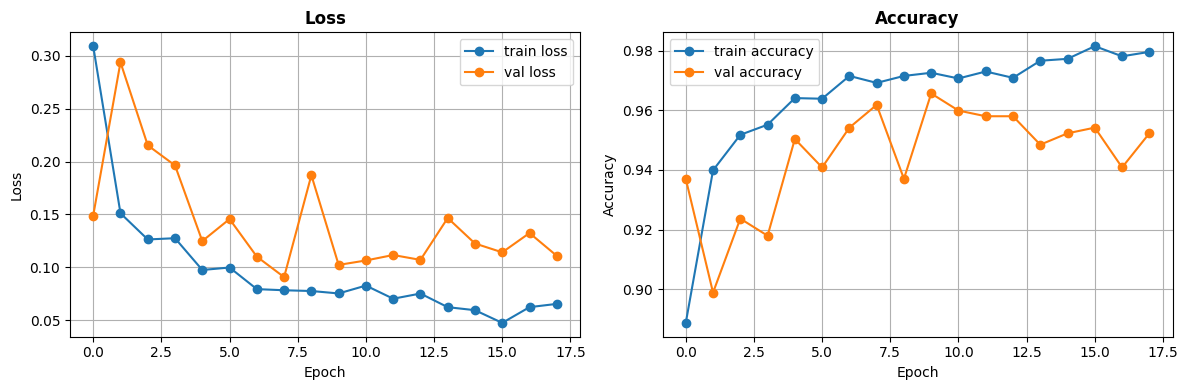

In [ ]:
# Plotting Loss and Accuracy Curves
hist = history.history

# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], marker='o', label='train loss')
plt.plot(hist['val_loss'], marker='o', label='val loss')
plt.title('Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(hist['binary_accuracy'], marker='o', label='train accuracy')
plt.plot(hist['val_binary_accuracy'], marker='o', label='val accuracy')
plt.title('Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Evaluation**

Loading best model: /content/drive/MyDrive/chest_xray/vgg16_models/Vgg16_Best_20250818_111540.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 62s 62s/step - auc: 0.9773 - binary_accuracy: 0.8926 - loss: 0.3150 - precision: 0.8549 - recall: 0.9974

Test Loss: 0.3150
Test Accuracy: 0.89263
1/1 ━━━━━━━━━━━━━━━━━━━━ 62s 62s/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9941    0.7179    0.8337       234
   PNEUMONIA     0.8549    0.9974    0.9207       390

    accuracy                         0.8926       624
   macro avg     0.9245    0.8577    0.8772       624
weighted avg     0.9071    0.8926    0.8881       624



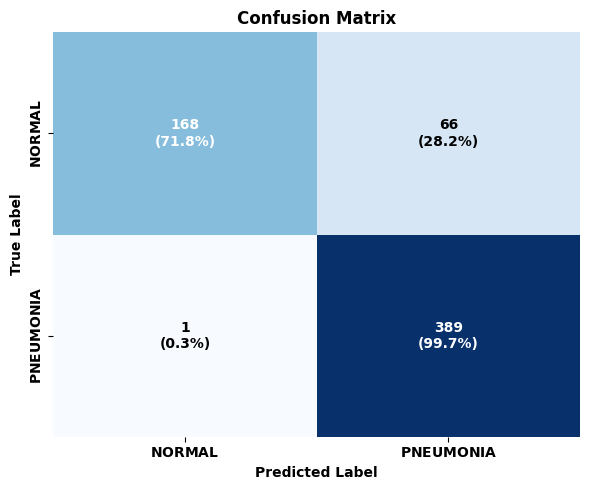

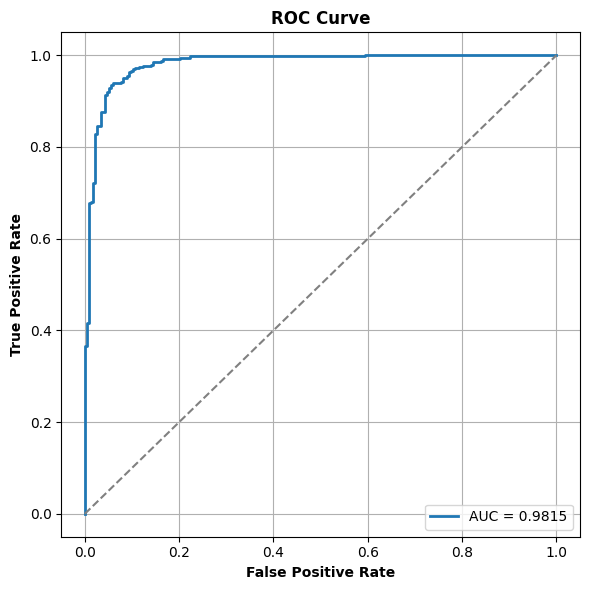


Model Size: 75.74 MB


In [ ]:
# Evaluate from the best saved model
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import glob, os
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define model_dir within this cell
model_dir = "/content/drive/MyDrive/chest_xray/vgg16_models"

# Load the latest saved "best" VGG model (pattern: vgg16_best_YYYYmmdd_HHMMSS.h5)
best_files = sorted(glob.glob(os.path.join(model_dir, "Vgg16_Best_*.h5")))
best_model_path = best_files[-1]  # Get the path of the latest saved best model
print("Loading best model:", best_model_path)
model = load_model(best_model_path)

# Re-compile the model with the same metrics after loading
model.compile(
    optimizer=Adam(learning_rate=3e-3),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
    ]
)

# Evaluate the model on the test set
# Unpack all the metrics returned by model.evaluate
loss, precision, recall, auc, binary_accuracy = model.evaluate(test_gen, verbose=1)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {binary_accuracy:.5f}")
# print(f"Test Precision: {precision:.4f}")
# print(f"Test Recall: {recall:.4f}")
# print(f"Test AUC: {auc:.4f}")


# Get predictions
y_true  = test_data['target'].values # Get true labels from test_data DataFrame
y_probs = model.predict(test_gen, verbose=1).ravel()
y_pred  = (y_probs > 0.50).astype(int)

# Classification report (4 decimals)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_map.keys()), digits=4))

# Confusion matrix with counts + row-wise %
cm = confusion_matrix(y_true, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100.0

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"$\\bf{{{lbl}}}$" for lbl in class_map.keys()],
    yticklabels=[f"$\\bf{{{lbl}}}$" for lbl in class_map.keys()],
    cbar=False
)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_percent[i, j]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{count}\n({pct:.1f}%)",
            ha='center',
            va='center',
            color='white' if i == j else 'black',
            fontweight='bold'
        )
plt.title("Confusion Matrix", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()

# ROC AUC
auc_score = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.title("ROC Curve", fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc="lower right", frameon=True)
plt.grid(True)
plt.tight_layout()
plt.show()

# Model size
model_size_mb = os.path.getsize(best_model_path) / (1024 * 1024)
print(f"\nModel Size: {model_size_mb:.2f} MB")